<br/>**Task 2**<br/>
**Problem Statement:**<br/>
Implement a circuit that returns $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability.

**Requirements:**

The circuit should consist only of CNOTs, RXs and RYs.
Start from all parameters in parametric gates being equal to 0 or randomly chosen.
You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like).
Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise.
Compare the results for different numbers of measurements: 1, 10, 100, 1000.

**Bonus question: How to make sure you produce state $\lvert01\rangle$ + $\lvert10\rangle$ and not $\lvert01\rangle$ - $\lvert10\rangle$?**

**Software Used:** Qiskit(0.20.0)

# Simple Bell Pair Generater

In [143]:
import qiskit as q
import numpy as np
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
noise_model = noise.NoiseModel()


## Sample Bell Pair Reference

A reference circuit that creates the state $\lvert\psi\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}\lvert10\rangle$ (upto a global phase) using only RX, RY, and CX gates. The intention behind this was just to get a feel of the RX and RY gates and do some visualization...

### Creating the circuit with H and X and CNOT¶


In [141]:
    qc = q.QuantumCircuit(2)
    qc.h(0)
    qc.x(1)
    qc.cx(0,1)
    meas = q.QuantumCircuit(2, 2)
    meas.barrier(range(2))
    
    # map the quantum measurement to the classical bits
    meas.measure(range(2),range(2))
    qc = qc + meas
    qc.draw()
    

┌───┐      ░ ┌─┐   
q_0: ┤ H ├──■───░─┤M├───
     ├───┤┌─┴─┐ ░ └╥┘┌─┐
q_1: ┤ X ├┤ X ├─░──╫─┤M├
     └───┘└───┘ ░  ║ └╥┘
c_0: ══════════════╩══╬═
                      ║ 
c_1: ═════════════════╩═

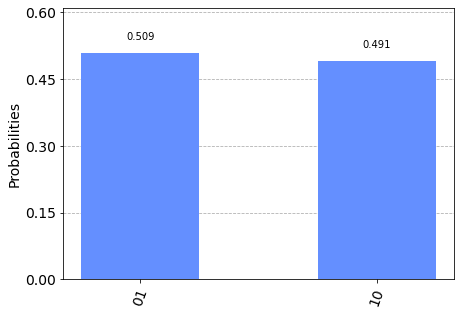

In [142]:
backend = Aer.get_backend('qasm_simulator')
results = q.execute(qc, backend, shots = 1000).result()
counts = results.get_counts(qc)
plot_histogram(counts)

### Creating the circuit with RY , RX  and CNOT¶


In [3]:
def bell_pair(param):
    """Takes input of parameters for Rx and Ry gates returns circuit to be optimized."""
    
    theta_x_1 = param[0]
    theta_y_1 = param[1]
    theta_x_2 = param[2]
    theta_y_2 = param[3]

    qc = q.QuantumCircuit(2)
    qc.ry(theta_y_2,1)
    qc.rx(theta_x_2,1)
    #Hadamard Gate for q0
    qc.ry(theta_y_1, 0) 
    qc.rx(theta_x_1, 0)
    #CX Gate
    qc.cx(0, 1)
    
    meas = q.QuantumCircuit(2, 2)
    meas.barrier(range(2))
    
    # map the quantum measurement to the classical bits
    meas.measure(range(2),range(2))
    
    qc = qc + meas
    
    return qc

In [4]:
ang_x_1 = np.pi 
ang_y_1 = np.pi /2
ang_x_2= np.pi
ang_y_2=0
qc = bell_pair([ang_x_1, ang_y_1,ang_x_2,ang_y_2])

In [5]:
qc.draw()

┌──────────┐┌────────┐      ░ ┌─┐   
q_0: ┤ RY(pi/2) ├┤ RX(pi) ├──■───░─┤M├───
     └┬───────┬─┘├────────┤┌─┴─┐ ░ └╥┘┌─┐
q_1: ─┤ RY(0) ├──┤ RX(pi) ├┤ X ├─░──╫─┤M├
      └───────┘  └────────┘└───┘ ░  ║ └╥┘
c_0: ═══════════════════════════════╩══╬═
                                       ║ 
c_1: ══════════════════════════════════╩═

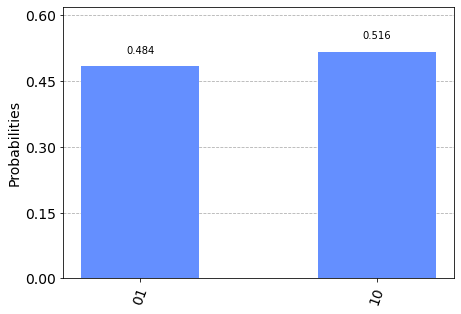

In [6]:
backend = Aer.get_backend('qasm_simulator')
results = q.execute(qc, backend, shots = 1000).result()
counts = results.get_counts(qc)
plot_histogram(counts)

# Optimiser(Noiseless)

In [7]:
def objective_function(params):
    """Calculates and returns the distance between the simulated distribution 
    and the target distribution. Note the global constants NUM_SHOTS and TARGET_DIST 
    need to be defined before calling this function."""
    
    # builds the quantum circuit using the angles in params.
    qc = bell_pair(params)
    
    # executes the circuit using the qasm simulator
    backend = Aer.get_backend('qasm_simulator')
    results = q.execute(qc, backend, shots = NUM_SHOTS).result()
    counts = results.get_counts(qc)
    
    # Normalises the counts to create an output probability disitrbution 
    output_dist = {key: value / NUM_SHOTS for key, value in counts.items()}
    
    #computes the cost function and returns it
    cost = 0
    for key, value in output_dist.items():
        cost += np.abs(value - TARGET_DIST[key])
        
    return cost

In [102]:
def find_opt(target, shots):
    #set up optimizer
    optimizer = COBYLA(maxiter=15000, tol=1e-10)
    # Create the initial parameters
    params = np.random.rand(4)
    NUM_SHOTS = shots
    TARGET_DIST = target

    return optimizer.optimize(num_vars=4, objective_function=objective_function, initial_point=params)

In [105]:
TARGET_DIST = {'00' : 0.0, '11' : 0.0, '01' : 0.5, '10' : 0.5}
# We are looking for |01> and |11>
ans_list = []
for NUM_SHOTS in [1, 10, 100, 1000]:

    opt_out = find_opt(TARGET_DIST, NUM_SHOTS)
    backend = Aer.get_backend('qasm_simulator')

    # Obtain the output distribution using the final parameters
    output_qc = bell_pair(opt_out[0])
    counts = q.execute(output_qc, backend, shots=NUM_SHOTS).result().get_counts(output_qc)
    output_distr = {key: value / NUM_SHOTS for key, value in counts.items()}
    ans_list.append(counts)

    print("Target Distribution:", TARGET_DIST)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", opt_out[1])
    print("Output Objective Function:", objective_function(opt_out[0]))
    print("Parameters Found:", opt_out[0])
    plot_histogram(counts)

Target Distribution: {'00': 0.0, '11': 0.0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'10': 1.0}
Output Error (Manhattan Distance): 0.5
Output Objective Function: 1.0
Parameters Found: [1.15464591 0.75970201 0.44664077 0.9008266 ]
Target Distribution: {'00': 0.0, '11': 0.0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'01': 0.1, '10': 0.9}
Output Error (Manhattan Distance): 0.19999999999999996
Output Objective Function: 0.0
Parameters Found: [ 1.38247649  0.28939475  3.08949262 -0.16892873]
Target Distribution: {'00': 0.0, '11': 0.0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'01': 0.51, '11': 0.02, '00': 0.05, '10': 0.42}
Output Error (Manhattan Distance): 0.46
Output Objective Function: 0.16000000000000003
Parameters Found: [ 2.05173315  1.65024542  3.19669247 -0.56057099]
Target Distribution: {'00': 0.0, '11': 0.0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'01': 0.483, '11': 0.006, '00': 0.008, '10': 0.503}
Output Error (Manhattan Distance): 0.05000000000000003
Output Ob

## Plot of Optimisation(Noiseless)

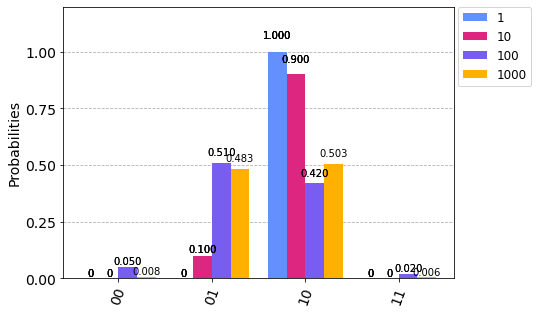

In [106]:
plot_histogram(ans_list, legend =['1', '10', '100', '1000'])


**Conclusion** : The accuracy of the parameters goes on improving as we increase the number of shots.

# Optimiser(Noisy)

In [107]:
def objective_function_noisy(params):
    """Calculates and returns the distance between the simulated distribution 
    and the target distribution. Note the global constants NUM_SHOTS and TARGET_DIST 
    need to be defined before calling this function."""
    
    # builds the quantum circuit using the angles in params.
    qc = bell_pair(params)
    
    
    #########################################
    #noise added to the execute now
    #########################################
    # executes the circuit using the qasm simulator 
    backend = Aer.get_backend('qasm_simulator')
    results = q.execute(qc, backend, shots = NUM_SHOTS, noise_model=noise_model).result()
    counts = results.get_counts(qc)
    
    # Normalises the counts to create an output probability disitrbution 
    output_dist = {key: value / NUM_SHOTS for key, value in counts.items()}
    
    #computes the cost function and returns it
    cost = 0
    for key, value in output_dist.items():
        cost += np.abs(value - TARGET_DIST[key])
        
    return cost

In [135]:
def find_opt_noisy(target, shots):
    
    
    #set up optimizer
    optimizer = COBYLA(maxiter=5000, tol=1e-50)

    # Create the initial parameters
    params = np.random.rand(4)
    NUM_SHOTS = shots
    TARGET_DIST = target

    return optimizer.optimize(num_vars=4, objective_function=objective_function_noisy, initial_point=params)

In [136]:
TARGET_DIST = {'00' : 0, '11' : 0, '01' : 0.5, '10' : 0.5}
err=[]
ans_list = []
parameter_list = []
for NUM_SHOTS in [1, 10, 100, 1000]:

    opt_out = find_opt_noisy(TARGET_DIST, NUM_SHOTS)
    parameter_list.append(opt_out[0])

    # Obtain the output distribution using the final parameters
    output_qc = bell_pair(opt_out[0])
    counts = q.execute(output_qc, backend, shots=NUM_SHOTS, noise_model = noise_model).result().get_counts(output_qc)
    output_distr = {key: value / NUM_SHOTS for key, value in counts.items()}
    ans_list.append(counts)

    print("Target Distribution:", TARGET_DIST)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", opt_out[1])
    print("Output Objective Function:", objective_function_noisy(opt_out[0]))
    print("Parameters Found:", opt_out[0])
    err.append({NUM_SHOTS:opt_out[1]})

Target Distribution: {'00': 0, '11': 0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'10': 1.0}
Output Error (Manhattan Distance): 0.5
Output Objective Function: 1.0
Parameters Found: [0.39194615 0.65756684 0.9851675  1.84245178]
Target Distribution: {'00': 0, '11': 0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'01': 0.6, '00': 0.1, '10': 0.3}
Output Error (Manhattan Distance): 0.6000000000000001
Output Objective Function: 0.6000000000000001
Parameters Found: [ 1.52736668 -0.52391418 -0.15796739  2.19822629]
Target Distribution: {'00': 0, '11': 0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'01': 0.27, '11': 0.13, '00': 0.12, '10': 0.48}
Output Error (Manhattan Distance): 0.62
Output Objective Function: 0.45999999999999996
Parameters Found: [1.41797191 0.60880623 0.75992732 2.45451723]
Target Distribution: {'00': 0, '11': 0, '01': 0.5, '10': 0.5}
Obtained Distribution: {'01': 0.498, '11': 0.022, '00': 0.024, '10': 0.456}
Output Error (Manhattan Distance): 0.126
Output Objective F

## Plot of Optimisation(Noisy)

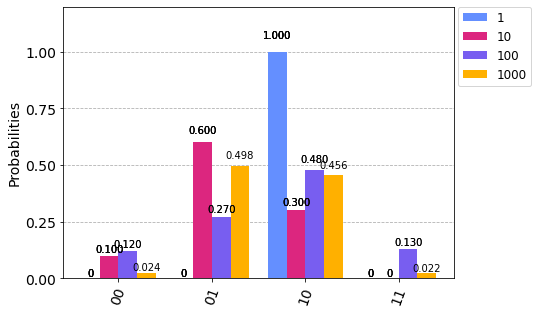

In [137]:
plot_histogram(ans_list, legend =['1', '10', '100', '1000'])


# Bonus Section


How do we prepare **$|01\rangle + |10\rangle$** and **not** **$|01\rangle - |10\rangle$**?

**Solution**
First we define the same circuit but add another X gate and entanglement circuit , such that on measurement, the value of,<br/>
<t/>$|01\rangle + |10\rangle$ is **0**<br/>
$|01\rangle - |10\rangle$ is **1** , as shown below,

In [155]:
def bell_pair(param):
    """Takes input of parameters for Rx and Ry gates returns circuit to be optimized."""
    
    theta_x_1 = param[0]
    theta_y_1 = param[1]
    theta_x_2 = param[2]
    theta_y_2 = param[3]

    qc = q.QuantumCircuit(2)
    qc.ry(theta_y_2,1)
    qc.rx(theta_x_2,1)
    #Hadamard Gate for q0
    qc.ry(theta_y_1, 0) 
    qc.rx(theta_x_1, 0)
    #CX Gate
    qc.cx(0, 1)
    #Testing Comppunents
    qc.x(0)
    qc.cx(0,1)
    qc.h(0)
    meas = q.QuantumCircuit(2, 1)
    meas.barrier(range(2))
    
    # map the quantum measurement to the classical bits
    meas.measure(0,0)
    
    qc = qc + meas
    
    return qc

In [156]:
ang_x_1 = np.pi 
ang_y_1 = np.pi /2
ang_x_2= np.pi
ang_y_2=0
qc = bell_pair([ang_x_1, ang_y_1,ang_x_2,ang_y_2])
qc.draw()

┌──────────┐┌────────┐     ┌───┐     ┌───┐ ░ ┌─┐
q_0: ┤ RY(pi/2) ├┤ RX(pi) ├──■──┤ X ├──■──┤ H ├─░─┤M├
     └┬───────┬─┘├────────┤┌─┴─┐└───┘┌─┴─┐└───┘ ░ └╥┘
q_1: ─┤ RY(0) ├──┤ RX(pi) ├┤ X ├─────┤ X ├──────░──╫─
      └───────┘  └────────┘└───┘     └───┘      ░  ║ 
c_0: ══════════════════════════════════════════════╩═

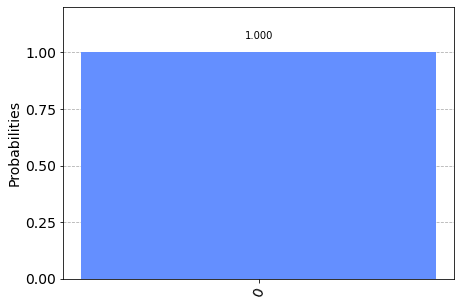

In [157]:
backend = Aer.get_backend('qasm_simulator')
results = q.execute(qc, backend, shots = 1000).result()
counts = results.get_counts(qc)
plot_histogram(counts)

**The given circuit produces $|01\rangle + |10\rangle$**

In [162]:
ang_x_1 = np.pi 
ang_y_1 = -np.pi /2
ang_x_2= np.pi
ang_y_2=0
qc = bell_pair([ang_x_1, ang_y_1,ang_x_2,ang_y_2])
qc.draw()

┌───────────┐┌────────┐     ┌───┐     ┌───┐ ░ ┌─┐
q_0: ┤ RY(-pi/2) ├┤ RX(pi) ├──■──┤ X ├──■──┤ H ├─░─┤M├
     └─┬───────┬─┘├────────┤┌─┴─┐└───┘┌─┴─┐└───┘ ░ └╥┘
q_1: ──┤ RY(0) ├──┤ RX(pi) ├┤ X ├─────┤ X ├──────░──╫─
       └───────┘  └────────┘└───┘     └───┘      ░  ║ 
c_0: ═══════════════════════════════════════════════╩═

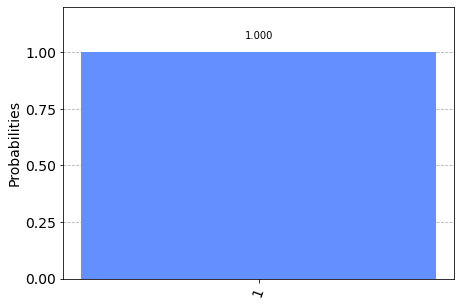

In [163]:
backend = Aer.get_backend('qasm_simulator')
results = q.execute(qc, backend, shots = 1000).result()
counts = results.get_counts(qc)
plot_histogram(counts)

**The given circuit produces $|01\rangle - |10\rangle$**

## Optimisation(Noiseless)

In [173]:
def objective_function(params):
    """Calculates and returns the distance between the simulated distribution 
    and the target distribution. Note the global constants NUM_SHOTS and TARGET_DIST 
    need to be defined before calling this function."""
    
    # builds the quantum circuit using the angles in params.
    qc = bell_pair(params)
    
    # executes the circuit using the qasm simulator
    backend = Aer.get_backend('qasm_simulator')
    results = q.execute(qc, backend, shots = NUM_SHOTS).result()
    counts = results.get_counts(qc)
    
    # Normalises the counts to create an output probability disitrbution 
    output_dist = {key: value / NUM_SHOTS for key, value in counts.items()}
    
    #computes the cost function and returns it
    cost = 0
    for key, value in output_dist.items():
        cost += np.abs(value - TARGET_DIST[key])
        
    return cost

In [174]:
def find_opt(target, shots):
    #set up optimizer
    optimizer = COBYLA(maxiter=15000, tol=1e-10)
    # Create the initial parameters
    params = np.random.rand(4)
    NUM_SHOTS = shots
    TARGET_DIST = target

    return optimizer.optimize(num_vars=4, objective_function=objective_function, initial_point=params)

In [175]:
TARGET_DIST = {'0' : 1.0, '1' : 0.0}
# We are looking for |01> and |11>
ans_list = []
for NUM_SHOTS in [1, 10, 100, 1000]:

    opt_out = find_opt(TARGET_DIST, NUM_SHOTS)
    backend = Aer.get_backend('qasm_simulator')

    # Obtain the output distribution using the final parameters
    output_qc = bell_pair(opt_out[0])
    counts = q.execute(output_qc, backend, shots=NUM_SHOTS).result().get_counts(output_qc)
    output_distr = {key: value / NUM_SHOTS for key, value in counts.items()}
    ans_list.append(counts)

    print("Target Distribution:", TARGET_DIST)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", opt_out[1])
    print("Output Objective Function:", objective_function(opt_out[0]))
    print("Parameters Found:", opt_out[0])
    plot_histogram(counts)

Target Distribution: {'0': 1.0, '1': 0.0}
Obtained Distribution: {'0': 1.0}
Output Error (Manhattan Distance): 0.0
Output Objective Function: 0.0
Parameters Found: [0.0906803  0.78335098 0.09722987 0.96708074]
Target Distribution: {'0': 1.0, '1': 0.0}
Obtained Distribution: {'1': 0.1, '0': 0.9}
Output Error (Manhattan Distance): 0.39999999999999997
Output Objective Function: 0.0
Parameters Found: [1.81707852 0.99306302 0.27126895 0.9783844 ]
Target Distribution: {'0': 1.0, '1': 0.0}
Obtained Distribution: {'1': 0.02, '0': 0.98}
Output Error (Manhattan Distance): 0.02000000000000001
Output Objective Function: 0.04000000000000002
Parameters Found: [1.42228967 1.80835849 0.73531948 1.29023931]
Target Distribution: {'0': 1.0, '1': 0.0}
Obtained Distribution: {'0': 1.0}
Output Error (Manhattan Distance): 0.0
Output Objective Function: 0.002000000000000001
Parameters Found: [1.24804112 1.60045548 1.5730014  0.52340848]


### Plot for Optmisation

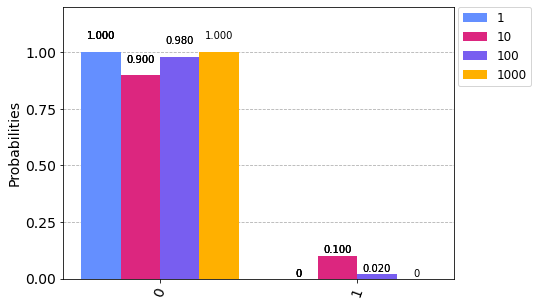

In [176]:
plot_histogram(ans_list, legend =['1', '10', '100', '1000'])


**In conclusion the optimisation does work fine and most of output is of form $|01\rangle + |10\rangle$**

TODO
- Plot graphs - cost vs iteration(With / Without Noise)
- Experiment with pennylane optimisation library.
- Add a more mathematical overview of how it works.

# Refrences
- [Qiskit COBYLA](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.COBYLA.html)
- [Quantum Circuit Parameters Learning with Gradient Descent](https://arxiv.org/pdf/1910.14266.pdf)